In [56]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import tensorflow as tf  # Importar TensorFlow
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

# Configuración de credenciales de la API de Kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download -c clasificar-texto-lstm
#! unzip clasificar-texto-lstm.zip


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
# Cargar datos de entrenamiento y prueba
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
lista_titulos = df_train['titulo'].tolist()

# Inicializar tokenizer y stopwords
tokenizador = ToktokTokenizer()
stopwords_espanol = set(stopwords.words('spanish'))

# Función para remover acentos
def eliminar_acentos(texto):
    return ''.join(c for c in unicodedata.normalize('NFKD', texto) if not unicodedata.combining(c))

# Función para preprocesar texto
def preprocesar_texto(texto):
    texto = eliminar_acentos(texto)
    texto = texto.lower()
    texto = re.sub(r'\W+', ' ', texto)
    return texto

# Función para aplicar stemming
def aplicacion_stemming(texto):
    stemmer = PorterStemmer()
    tokens = tokenizador.tokenize(texto)
    tokens = [stemmer.stem(token.strip()) for token in tokens if token not in stopwords_espanol]
    return " ".join(tokens).strip('"')

# Función para contar palabras
def contar_palabras(titulos):
    dicc_palabras = defaultdict(int)
    for titulo in titulos:
        titulo_preprocesado = preprocesar_texto(titulo)
        palabras = titulo_preprocesado.split()
        for palabra in palabras:
            dicc_palabras[palabra] += 1
    return dicc_palabras

# Preprocesar y aplicar stemming a los títulos
titulos_procesados = [aplicacion_stemming(preprocesar_texto(titulo)) for titulo in lista_titulos]
cuenta_palabras = contar_palabras(titulos_procesados)

# Contar total de palabras únicas y repeticiones
total_palabras_unicas = len(cuenta_palabras)
total_repeticiones_palabras = sum(cuenta_palabras.values())

print(f'Total de palabras únicas: {total_palabras_unicas}')
print(f'Total de palabras repetidas: {total_repeticiones_palabras}')


Total de palabras únicas: 1687
Total de palabras repetidas: 4323


Palabras más frecuentes:
vemo: 206
televident: 95
capitulo: 67
glosario: 54
senal: 48
cine: 38
completo: 33
m: 32
today: 32
in: 32
replay: 32
colombia: 31
30: 30
p: 29
00: 28
6: 25
saludo: 23
2: 21
mundial: 21
directo: 20


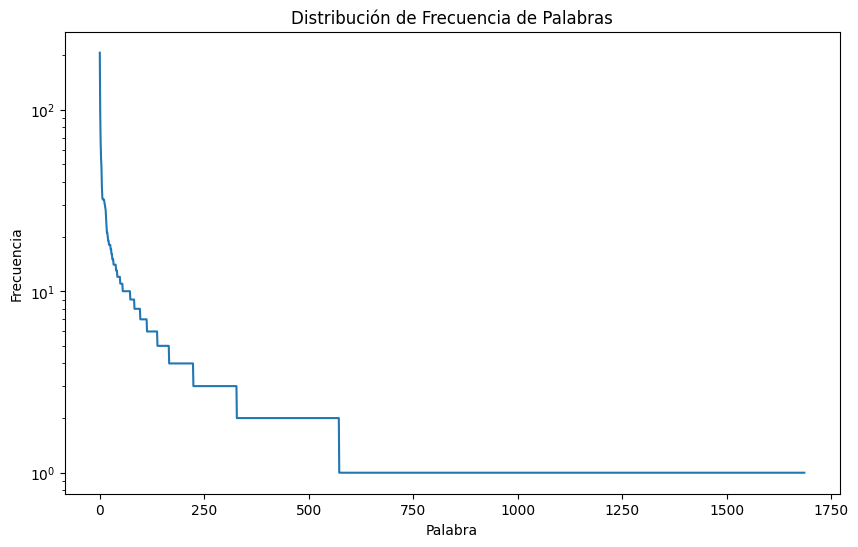

In [58]:
# Crear índice de palabras
lista_palabras_unicas = list(cuenta_palabras.keys())
indice_palabras = {palabra: i for i, palabra in enumerate(lista_palabras_unicas)}

# Crear matriz de palabras
matriz_palabras = np.zeros((len(df_train), len(lista_palabras_unicas)))
for i, titulo in enumerate(titulos_procesados):
    palabras = titulo.split()
    for palabra in palabras:
        if palabra in indice_palabras:
            matriz_palabras[i, indice_palabras[palabra]] += 1

# Obtener palabras más frecuentes
cuentas_ordenadas = sorted(cuenta_palabras.items(), key=lambda item: item[1], reverse=True)
print("Palabras más frecuentes:")
for palabra, cuenta in cuentas_ordenadas[:20]:
    print(f"{palabra}: {cuenta}")

frecuencias = [cuenta for palabra, cuenta in cuentas_ordenadas]

# Graficar distribución de frecuencia de palabras
plt.figure(figsize=(10, 6))
plt.plot(frecuencias)
plt.yscale('log')
plt.title('Distribución de Frecuencia de Palabras')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()


In [59]:
# Filtrar stopwords
palabras_filtradas = [palabra for palabra in lista_palabras_unicas if palabra not in stopwords_espanol]
indice_palabras_filtradas = {palabra: i for i, palabra in enumerate(palabras_filtradas)}

# Crear matriz de palabras filtradas
matriz_palabras_filtradas = np.zeros((len(df_train), len(palabras_filtradas)))
for i, titulo in enumerate(titulos_procesados):
    palabras = titulo.split()
    for palabra in palabras:
        if palabra in indice_palabras_filtradas:
            matriz_palabras_filtradas[i, indice_palabras_filtradas[palabra]] += 1

# Crear matriz de frecuencia de términos (TF)
matriz_tf = matriz_palabras_filtradas / np.maximum(matriz_palabras_filtradas.sum(axis=1, keepdims=True), 1)

# Crear variables dummy para las categorías objetivo
vars_dummy_categoria = pd.get_dummies(df_train['categoria'])

# Combinar matriz TF con variables dummy
df_tf = pd.DataFrame(matriz_tf, columns=palabras_filtradas)
df_combinado = pd.concat([vars_dummy_categoria.reset_index(drop=True), df_tf.reset_index(drop=True)], axis=1)

# Calcular matriz de correlación
matriz_correlacion = df_combinado.corr()
correlacion_categoria_termino = matriz_correlacion.loc[vars_dummy_categoria.columns, df_tf.columns]

print("Matriz de correlación entre categorías y términos:")
print(correlacion_categoria_termino)

# Calcular vector de IDF (Frecuencia Inversa de Documentos)
num_titulos_con_palabra = np.sum(matriz_palabras_filtradas > 0, axis=0)
vector_idf = np.log((len(df_train) + 1) / (num_titulos_con_palabra + 1))

# Crear matriz TF-IDF
matriz_tf_idf = matriz_tf * vector_idf


Matriz de correlación entre categorías y términos:
                        sirven   triunfo        si       paz    corona  \
Deportes             -0.019676  0.053992 -0.038106 -0.000761 -0.019676   
Educación            -0.014348 -0.023645 -0.027787 -0.023908 -0.014348   
Entretenimiento      -0.021993 -0.036245  0.044659  0.024032 -0.021993   
Gente y Blogs        -0.009518 -0.015686 -0.018434 -0.015860 -0.009518   
Otros                -0.008938 -0.014730 -0.017310 -0.014894 -0.008938   
Película y Animación  0.067350  0.021826  0.035404  0.013094  0.067350   

                      lapazhabla     mejor     forma   mostrar    pensar  ...  \
Deportes               -0.019676 -0.067425  0.015863 -0.019676 -0.019676  ...   
Educación              -0.014348 -0.049166 -0.019696 -0.014348 -0.014348  ...   
Entretenimiento        -0.021993 -0.062009 -0.030191 -0.021993 -0.021993  ...   
Gente y Blogs          -0.009518  0.132310 -0.013066 -0.009518 -0.009518  ...   
Otros                  -0

In [60]:
# Preprocesar y aplicar stemming a los títulos de prueba
lista_titulos_test = df_test['titulo'].tolist()
titulos_test_procesados = [aplicacion_stemming(preprocesar_texto(titulo)) for titulo in lista_titulos_test]

# Crear matriz de palabras para los datos de prueba
matriz_palabras_test = np.zeros((len(df_test), len(palabras_filtradas)))
for i, titulo in enumerate(titulos_test_procesados):
    palabras = titulo.split()
    for palabra in palabras:
        if palabra in indice_palabras_filtradas:
            matriz_palabras_test[i, indice_palabras_filtradas[palabra]] += 1

# Crear matriz TF para los datos de prueba
matriz_tf_test = matriz_palabras_test / np.maximum(matriz_palabras_test.sum(axis=1, keepdims=True), 1)

# Crear matriz TF-IDF para los datos de prueba
matriz_tf_idf_test = matriz_tf_test * vector_idf

# Dividir los datos de entrenamiento en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(matriz_tf_idf, df_train['categoria'], test_size=0.2, random_state=42)
X_test = matriz_tf_idf_test


In [61]:
# Entrenar modelo de regresión logística
modelo_regresion_logistica = LogisticRegression()
modelo_regresion_logistica.fit(X_train, y_train)

# Entrenar modelo de bosque aleatorio
modelo_bosque_aleatorio = RandomForestClassifier()
modelo_bosque_aleatorio.fit(X_train, y_train)

# Tokenizar títulos para la capa de embedding LSTM
tokenizador_keras = Tokenizer()
tokenizador_keras.fit_on_texts(titulos_procesados)
secuencias = tokenizador_keras.texts_to_sequences(titulos_procesados)
longitud_max_secuencia = max([len(seq) for seq in secuencias])
secuencias_rellenadas = pad_sequences(secuencias, maxlen=longitud_max_secuencia)

# Crear y compilar modelo LSTM
modelo_lstm = Sequential()
modelo_lstm.add(Embedding(len(tokenizador_keras.word_index) + 1, 20, input_length=longitud_max_secuencia))
modelo_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
modelo_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
modelo_lstm.add(Dense(32, activation='relu'))
modelo_lstm.add(Dense(1, activation='sigmoid'))
modelo_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [68]:
# Train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Train random forest model
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

# Tokenize titles for LSTM embedding layer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_titles)
sequences = tokenizer.texts_to_sequences(processed_titles)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Create and compile LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(len(tokenizer.word_index) + 1, 20, input_length=max_sequence_length))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [69]:
# Hacer predicciones con regresión logística
predicciones_regresion_logistica = modelo_regresion_logistica.predict(X_test)

# Hacer predicciones con bosque aleatorio
predicciones_bosque_aleatorio = modelo_bosque_aleatorio.predict(X_test)

# Tokenizar y rellenar datos de prueba para LSTM
secuencias_test_lstm = tokenizador_keras.texts_to_sequences(lista_titulos_test)
secuencias_rellenadas_test_lstm = pad_sequences(secuencias_test_lstm, maxlen=longitud_max_secuencia)
predicciones_lstm = modelo_lstm.predict(secuencias_rellenadas_test_lstm)

# Convertir predicciones LSTM a etiquetas
etiquetas_lstm = np.argmax(predicciones_lstm, axis=1)

# Asegurarse de que etiquetas_lstm sea una lista de enteros
etiquetas_lstm = etiquetas_lstm.tolist()

# Aplanar etiquetas_lstm para manejar listas anidadas
etiquetas_lstm_ajustadas = [item for sublist in etiquetas_lstm for item in sublist]

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(columns=['ID', 'categoria'])
df_resultados['ID'] = df_test['index']
df_resultados['categoria'] = predicciones_regresion_logistica

# Guardar resultados de regresión logística
df_resultados.to_csv('LR_results.csv', index=False)

# Guardar resultados de bosque aleatorio
df_resultados['categoria'] = predicciones_bosque_aleatorio
df_resultados.to_csv('RF_results.csv', index=False)

# Mapear predicciones de LSTM a etiquetas de categoría
mapa_categorias = {0: 'Entretenimiento', 1: 'Deportes', 2: 'Película y Animación', 3: 'Educación', 4: 'Otros'}

etiquetas_categoria_lstm = [mapa_categorias.get(etiqueta, 'Otro') for etiqueta in etiquetas_lstm_ajustadas]

df_resultados['categoria'] = etiquetas_categoria_lstm

# Guardar resultados de LSTM
df_resultados.to_csv('lstm_results.csv', index=False)

# Evaluar modelos
precision_regresion_logistica = precision_score(y_val, predicciones_regresion_logistica, average='weighted')
recall_regresion_logistica = recall_score(y_val, predicciones_regresion_logistica, average='weighted')
accuracy_regresion_logistica = accuracy_score(y_val, predicciones_regresion_logistica)

precision_bosque_aleatorio = precision_score(y_val, predicciones_bosque_aleatorio, average='weighted')
recall_bosque_aleatorio = recall_score(y_val, predicciones_bosque_aleatorio, average='weighted')
accuracy_bosque_aleatorio = accuracy_score(y_val, predicciones_bosque_aleatorio)

precision_lstm = precision_score(y_val, etiquetas_lstm_ajustadas, average='weighted')
recall_lstm = recall_score(y_val, etiquetas_lstm_ajustadas, average='weighted')
accuracy_lstm = accuracy_score(y_val, etiquetas_lstm_ajustadas)

# Matriz de confusión
matriz_confusion_regresion_logistica = confusion_matrix(y_val, predicciones_regresion_logistica)
matriz_confusion_bosque_aleatorio = confusion_matrix(y_val, predicciones_bosque_aleatorio)
matriz_confusion_lstm = confusion_matrix(y_val, etiquetas_lstm_ajustadas)

print("Regresión logística:")
print("Precisión:", precision_regresion_logistica)
print("Recall:", recall_regresion_logistica)
print("Exactitud:", accuracy_regresion_logistica)
print("Matriz de Confusión:\n", matriz_confusion_regresion_logistica)

print("\nBosque Aleatorio:")
print("Precisión:", precision_bosque_aleatorio)
print("Recall:", recall_bosque_aleatorio)
print("Exactitud:", accuracy_bosque_aleatorio)
print("Matriz de Confusión:\n", matriz_confusion_bosque_aleatorio)

print("\nLSTM:")
print("Precisión:", precision_lstm)
print("Recall:", recall_lstm)
print("Exactitud:", accuracy_lstm)
print("Matriz de Confusión:\n", matriz_confusion_lstm)

# Gráficas adicionales
# Graficar matriz de confusión para regresión logística
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion_regresion_logistica, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.show()

# Graficar matriz de confusión para bosque aleatorio
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion_bosque_aleatorio, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Bosque Aleatorio')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.show()

# Graficar matriz de confusión para LSTM
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusion_lstm, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusión - LSTM')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.show()

# Graficar precisión de modelos
puntajes_exactitud = [accuracy_regresion_logistica, accuracy_bosque_aleatorio, accuracy_lstm]
nombres_modelos = ['Regresión Logística', 'Bosque Aleatorio', 'LSTM']
plt.figure(figsize=(8, 6))
sns.barplot(x=nombres_modelos, y=puntajes_exactitud)
plt.title('Comparación de Exactitud de Modelos')
plt.xlabel('Modelo')
plt.ylabel('Exactitud')
plt.ylim(0, 1)
plt.show()


7/7 [==============================] - 0s 20ms/step


ValueError: Found input variables with inconsistent numbers of samples: [160, 200]